In [3]:
!pip install transformers
!pip install datasets

In [4]:
import datasets
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import AutoTokenizer, GPTNeoXForCausalLM, pipeline

In [5]:
# tokenizer = AutoTokenizer.from_pretrained('EleutherAI/pythia-160m-deduped', revision='step3000')
# model = GPTNeoXForCausalLM.from_pretrained('EleutherAI/pythia-160m-deduped', revision='step3000')

generator = pipeline('text-generation', model='EleutherAI/pythia-160m-deduped')

model = generator.model
tokenizer = generator.tokenizer

model_original_lm_head = model.embed_out

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/569 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/396 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [6]:
class Steer(nn.Module):
  def __init__(self, lm_head: nn.Module, *, epsilon: float = 1e-3):
    super().__init__()

    self.epsilon = epsilon

    self.proj1 = nn.Linear(768, 1000, bias=False)
    self.proj2 = nn.Linear(1000, 768, bias=False)
    self.lm_head = lm_head

    with torch.no_grad():
      self.proj1.weight.normal_(std=1e-3)
      self.proj2.weight.normal_(std=1e-3)

  def set_steer_values(self, steer_values: torch.Tensor):
    self.steer_values = steer_values

  def forward(self, x: torch.Tensor):
    return self.lm_head(x + self.epsilon * self.proj2(self.proj1(x) * self.steer_values[:, None, None]))

for param in model.parameters():
  param.requires_grad = False

steer = Steer(model_original_lm_head)
model.embed_out = steer
# model.set_output_embeddings(steer)


In [7]:
sentiment_items = list(datasets.load_dataset("SetFit/sst5")['train'])
sentiment_scores = torch.tensor([item['label'] for item in sentiment_items]) * 0.5 - 1.0 # -> [-1.0, 1.0]
sentiment_texts = [item['text'] for item in sentiment_items]

class SentimentDataset(torch.utils.data.Dataset):
  def __init__(self, texts, scores):
    self.texts = texts
    self.scores = scores

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, index):
    return self.texts[index], self.scores[index]

sentiment_dataset = SentimentDataset(sentiment_texts, sentiment_scores)


README.md:   0%|          | 0.00/421 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


train.jsonl:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

dev.jsonl:   0%|          | 0.00/171k [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/343k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8544 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1101 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2210 [00:00<?, ? examples/s]

In [8]:
loader = DataLoader(sentiment_dataset, batch_size=64, shuffle=True)
tokenizer.pad_token = tokenizer.eos_token

optimizer = optim.Adam(model.parameters(), lr=1e-3)

current_loss = 0.0

for batch_index, (batch_texts, batch_scores) in enumerate(tqdm(loader)):
  optimizer.zero_grad()

  batch_tokenized = tokenizer(batch_texts, padding=True, return_tensors='pt')
  # print(batch_tokenized)
  # break

  # batch_scores = batch_scores.unsqueeze(1).expand(-1, batch_tokenized['input_ids'].shape[1])

  steer.set_steer_values(batch_scores)

  output = model(
    input_ids=batch_tokenized['input_ids'],
    attention_mask=batch_tokenized['attention_mask'],
    labels=batch_tokenized['input_ids'],
  )

  output.loss.backward()
  optimizer.step()

  batch_loss = output.loss.item() / len(batch_texts)
  current_loss += batch_loss
  # print(f'{batch_loss:.2f} {current_loss / (batch_index + 1):.2f}')

  # break

100%|██████████| 134/134 [34:54<00:00, 15.63s/it]


In [9]:
# model.generate(input_ids=tokenized['input_ids'][0, :], attention_mask=tokenized['attention_mask'][0, :], pad_token_id=tokenizer.eos_token_id)

# tokens = tokenizer("My opinion on Paris is", return_tensors='pt')
# print(tokenizer.decode(model.generate(**tokens, do_sample=True, max_length=50)[0]))

steer.set_steer_values(torch.tensor([1.0]))
[generation[0]['generated_text'] for generation in generator(["My opinion on Paris is"] * 5, max_length=30, do_sample=True, pad_token_id=tokenizer.eos_token_id)]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


["My opinion on Paris is that I have absolutely no problem finding a city to which there isn't exactly a whole lot of entertainment, but they always seem",
 'My opinion on Paris is that the city has gone ahead of everybody because everyone in Paris has the power to protect us. In other words, it cannot',
 'My opinion on Paris is that it’s the perfect atmosphere for a city, from quiet beaches to stunning skyscrapers to fabulous streets to',
 "My opinion on Paris is indeed absolutely balanced. I really didn't care that much before last night when I had this interview. He'll tell you that",
 'My opinion on Paris is that your experience is limited?\n\nI read this article yesterday, at 7:18 AM, and I think you must']

In [10]:
from transformers import pipeline

sentiment_pipeline = pipeline("sentiment-analysis", model='distilbert/distilbert-base-uncased-finetuned-sst-2-english', top_k=None)

def get_sentiment(texts: list[str]):
  results = sentiment_pipeline(texts)
  return [item['score'] for result in results for item in result if item['label'] == 'POSITIVE']

print(get_sentiment(["I love you", "I hate you"]))

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[0.9998656511306763, 0.0008870713063515723]


In [11]:
sentiment_pipeline(["Paris is okay", "I hate you"])

[[{'label': 'POSITIVE', 'score': 0.9998618364334106},
  {'label': 'NEGATIVE', 'score': 0.00013814063277095556}],
 [{'label': 'NEGATIVE', 'score': 0.9991129040718079},
  {'label': 'POSITIVE', 'score': 0.0008870713063515723}]]

In [12]:
sentiment_values = get_sentiment(sentiment_texts)

{'bodies': [<matplotlib.collections.PolyCollection at 0x7da1b4906d40>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x7da1b474e7a0>,
 'cmins': <matplotlib.collections.LineCollection at 0x7da1b4602260>,
 'cbars': <matplotlib.collections.LineCollection at 0x7da1b4603ac0>}

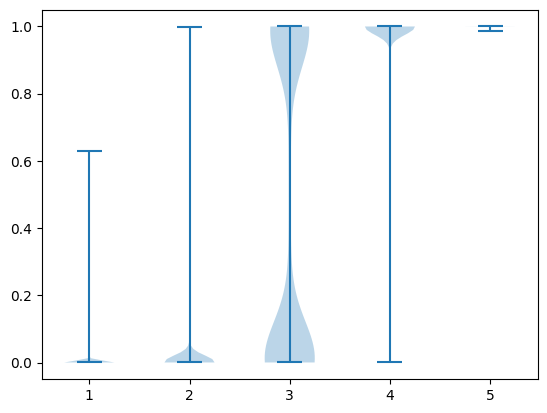

In [13]:
from matplotlib import pyplot as plt
import numpy as np

fig, ax = plt.subplots()

x = [np.array(sentiment_values)[sentiment_scores.numpy() == score] for score in [-1.0, -0.5, 0.0, 0.5, 1.0]]
ax.violinplot(x)

In [19]:
repeat_count = 10
steer_values = torch.tensor([-1.0, -0.5, 0.0, 0.5, 1.0])

cities = ['Paris', 'London', 'New York', 'Tokyo', 'Berlin', 'Rome', 'Moscow', 'Beijing', 'Sydney', 'Cairo']
result = torch.zeros((len(steer_values), len(cities), repeat_count)) * torch.nan

for steer_value_index, steer_value in enumerate(steer_values):
  steer.set_steer_values(torch.tensor([steer_value]))

  for city_index, city in enumerate(tqdm(cities)):
    generated_texts = [generation[0]['generated_text'] for generation in generator([f'My opinion of {city} is'] * repeat_count, max_length=30, do_sample=True, pad_token_id=tokenizer.eos_token_id)]
    # print(torch.mean(torch.tensor(get_sentiment(generated_texts))))
    result[steer_value_index, city_index, :] = torch.tensor(get_sentiment(generated_texts))

# for _ in range(count):
#   tokens = tokenizer("My opinion on Paris is", return_tensors='pt')
#   decoded = tokenizer.decode(model.generate(**tokens, do_sample=True, max_length=50)[0])

#   sentiment += get_sentiment([decoded])[0]

# print(sentiment / count)

  0%|          | 0/10 [00:07<?, ?it/s]


KeyboardInterrupt: 

In [26]:
sentiment = "neutral"

# Requires prompts from the paper's github repo (https://github.com/Glaciohound/LM-Steer/blob/main/data/prompts/sentiment_prompts-10k/positive_prompts.jsonl#L2498)
with open(sentiment + "_prompts.jsonl", "r") as f:
  prompt_data = list(map(json.loads, f.readlines()))

prompt_data = prompt_data[:10]

print(prompt_data[0]["prompt"]["text"])

God never intended to


In [28]:
repeat_count = 5
steer_values = torch.tensor([-1.0, -0.5, 0.0, 0.5, 1.0])

result = torch.zeros((len(steer_values), len(prompt_data), repeat_count)) * torch.nan

for steer_value_index, steer_value in enumerate(steer_values):
  steer.set_steer_values(torch.tensor([steer_value]))

  for city_index, prompt in enumerate(tqdm(prompt_data)):
    generated_texts = [generation[0]['generated_text'] for generation in generator([prompt["prompt"]["text"]] * repeat_count, max_length=30, do_sample=True, pad_token_id=tokenizer.eos_token_id)]
    # print(torch.mean(torch.tensor(get_sentiment(generated_texts))))
    result[steer_value_index, city_index, :] = torch.tensor(get_sentiment(generated_texts))


100%|██████████| 10/10 [01:09<00:00,  6.91s/it]


Text(0, 0.5, 'Positivity')

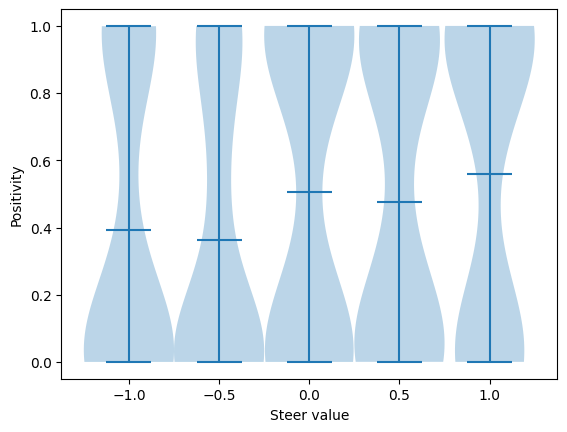

In [29]:
fig, ax = plt.subplots()

# ax.scatter(steer_values[:, None, None].broadcast_to(result.size()).ravel().numpy(), result.ravel().numpy())
ax.violinplot(result.numpy().reshape(len(steer_values), -1).T, steer_values.numpy(), showmeans=True)
ax.set_xlabel('Steer value')
ax.set_ylabel('Positivity')
# print(result.numpy().reshape(len(steer_values), -1).shape)

In [30]:
steer.set_steer_values(torch.tensor([-0.5]))
generator(f'My opinion of {cities[0]} is', do_sample=True)

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[{'generated_text': 'My opinion of Paris is simple. We love our country where we come from and all countries do better'}]

In [17]:
import json
from pathlib import Path


with Path('cities500.json').open() as file:
  cities = [city['name'] for city in json.load(file) if int(city['pop']) > 1_000_000]

FileNotFoundError: [Errno 2] No such file or directory: 'cities500.json'

In [ ]:
fig, ax = plt.subplots()
ax.hist(cities, bins=100, log=True);